In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
from functools import partial
import jax.example_libraries.optimizers as optimizers
import jax.random as random
key = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
from utils import init_params_nn, ff_nn, eval_Cauchy_aniso, train
from utils_node import init_params_aniso, NODE_model_aniso
from fem import plotmesh

from scipy.optimize import minimize

In [2]:
with open('params/circ_s100_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



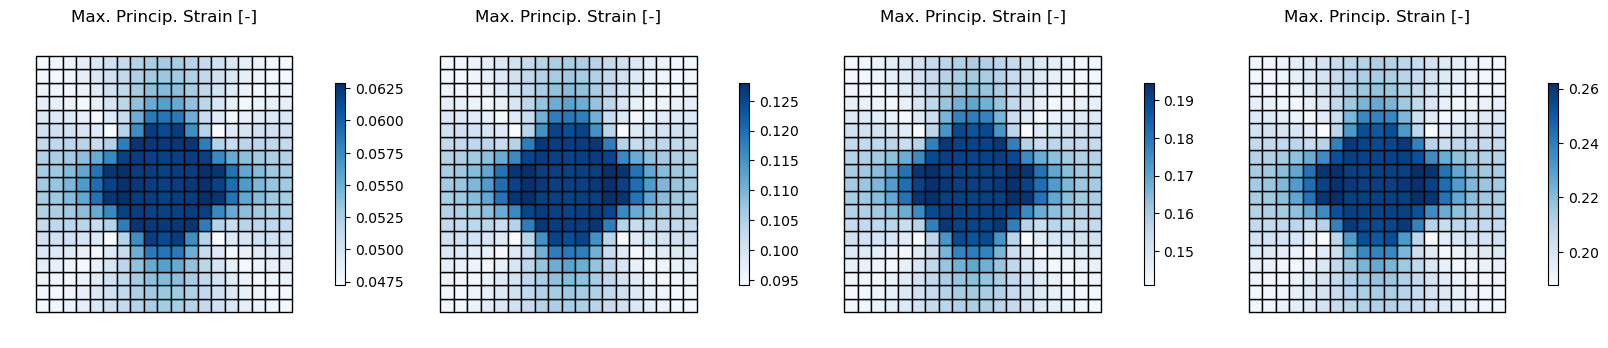

In [3]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [4]:
def VF1(x,y,h,w,p):
    U_x = x**p/w**p
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF2(x,y,h,w,p):
    U_x = 0.0
    U_y = y**p/h**p
    return jnp.stack([U_x,U_y]).T

def VF3(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    U_y = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    return jnp.stack([U_x,U_y]).T

def VF4(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    U_y = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    return jnp.stack([U_x,U_y]).T

def VF5(x,y,h,w,p):
    U_x = 1.0-(x/w-1)**(2*p)
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF6(x,y,h,w,p):
    U_x = 0.0
    U_y = 1.0-(y/h-1)**(2*p)
    return jnp.stack([U_x,U_y]).T

def VF_and_grad(VF, x, y, h, w, p):
    VF_dx = jax.jacfwd(VF, argnums=0)
    VF_dy = jax.jacfwd(VF, argnums=1)
    VF_grad = vmap(lambda x,y,h,w,p: jnp.stack([VF_dx(x,y,h,w,p), VF_dy(x,y,h,w,p)]).T, in_axes=(0,0,None,None,None))

    VF_vmap = vmap(VF, in_axes=(0,0,None,None,None))
    return VF_vmap(x,y,h,w,p), VF_grad(x,y,h,w,p)


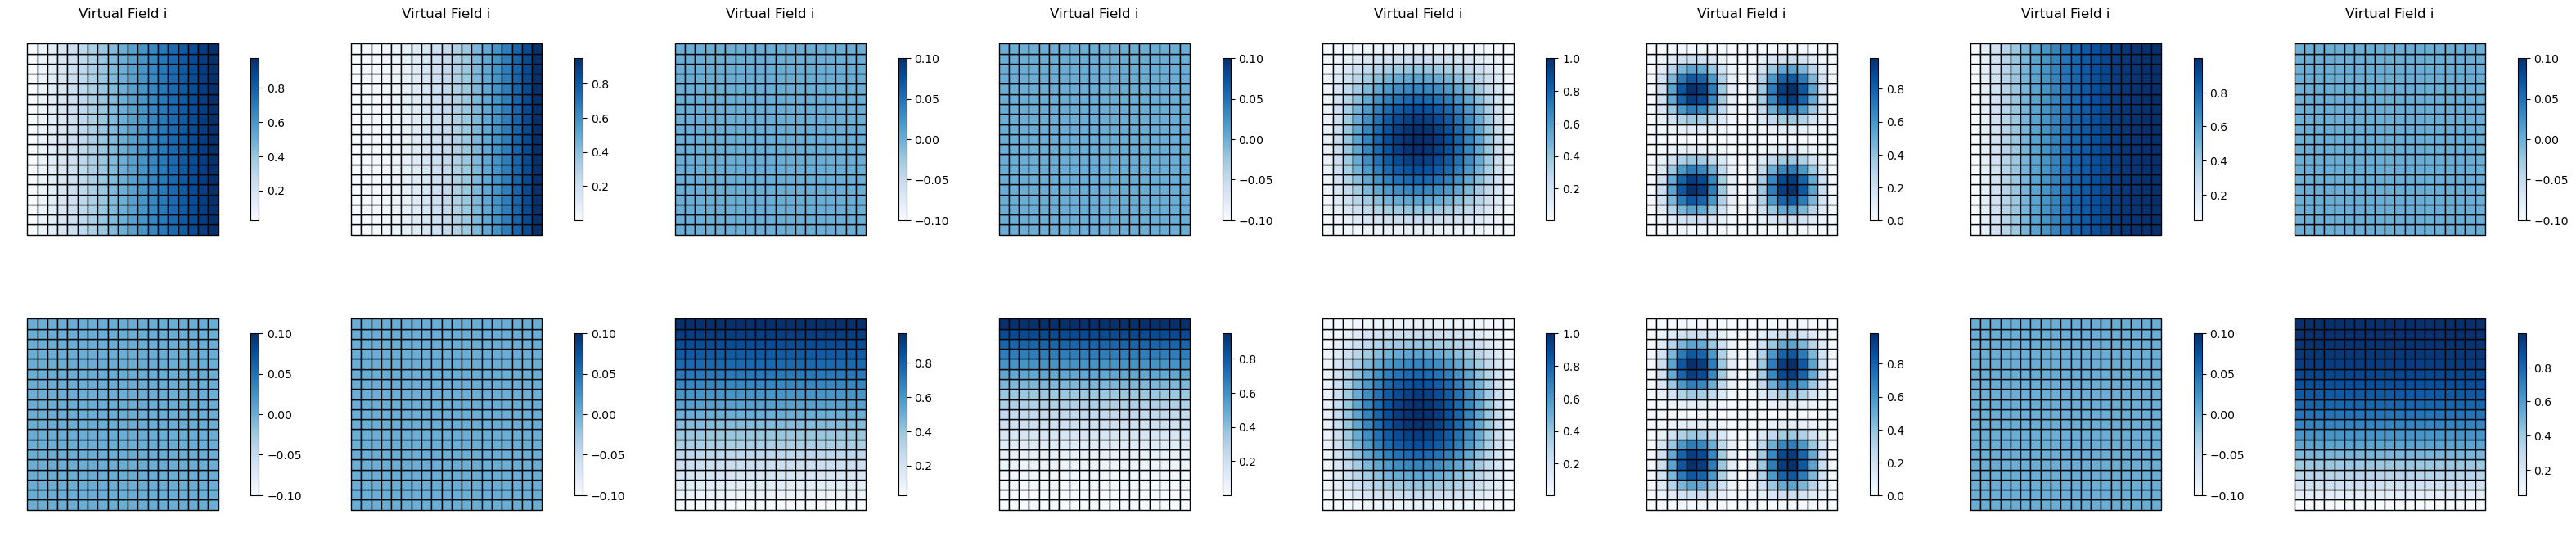

In [5]:
h = 1.0
w = 1.0
VF_list = [VF1, VF1, VF2, VF2, VF3, VF4, VF5, VF6]
p_list =  [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0]
# VF_list = [VF1, VF2, VF3, VF4]
# p_list =  [1.0, 1.0, 1.0, 2.0]
x, y = elem_X.T
U, gradU = [], []
fig, axes = plt.subplots(2,len(VF_list),figsize=(len(VF_list)*5,8))
for ax, VF, p in zip(axes.T, VF_list, p_list):
    Ui, gradUi = VF_and_grad(VF, x,y,h,w,p)
    plotmesh(mesh.cells, mesh.points, Ui[:,0], title='Virtual Field i', ax=ax[0]); 
    plotmesh(mesh.cells, mesh.points, Ui[:,1], title=None, ax=ax[1]); 
    U.append(Ui)
    gradU.append(gradUi)
U, gradU = np.array(U), np.array(gradU)

In [6]:
# Do the FEM with jax-fem instead
def NODE_PK1(lmbx, lmby, x, y, Lambda_params):
    Lambda_inp = jnp.array([x,y]).reshape([-1,2])
    params = ff_nn(Lambda_inp, Lambda_params).flatten()
    model = NODE_w_unravel(params)
    theta = model.theta
    
    #Kinematics
    F_2D = jnp.array([[lmbx, 0.0],
                      [0.0, lmby]])
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    # Energy/Stress
    Psi1 = model.Psi1(I1,I2,Iv,Iw)
    Psi2 = model.Psi2(I1,I2,Iv,Iw)
    Psiv = model.Psiv(I1,I2,Iv,Iw)
    Psiw = model.Psiw(I1,I2,Iv,Iw)
    
    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
NODE_vmap = vmap(NODE_PK1, in_axes=(0,0,0,0,None))

In [7]:
n_neurons = 4
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params_dummy = init_params_aniso(common_layers, sample_layers, key)
_, node_unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(node_unravel(params))
phi, unravel = ravel_pytree(node_params_dummy)
n_phi = len(phi)


n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
params_ravel, unravel = ravel_pytree(Lambda_params)


@jit
def obj_fn(Lambda_params):
    loss = []
    for step in range(len(F_hist_goh)):
        x, y = elem_X.T
        lmbx = F_hist_goh[step,:,0,0]
        lmby = F_hist_goh[step,:,1,1]
        P = NODE_vmap(lmbx, lmby, x, y, unravel(Lambda_params))
        # P = node_P_vmap()
        P = P[:,:2,:2]
        W_int = []
        W_ext = []
        for i_vf in range(len(U)):
            W_int.append(jnp.einsum('ijk,ijk', P, gradU[i_vf]))

            idx_rgt_and_top = U.shape[1] - 1 #We use U such that U is constant at the boundary. Therefore sampling U at one point on the bd is enough.
            idx_lft_and_bot = 0
            W_ext_rgt_bd = U[i_vf, idx_rgt_and_top, 0]*Fx[step]*19 # + the non-constant component of U * Fy=0 because we assume no shear loads at the boundary, i.e. Fy|_rgt = 0.
            W_ext_top_bd = U[i_vf, idx_rgt_and_top, 1]*Fy[step]*19
            W_ext.append(W_ext_rgt_bd + W_ext_top_bd)
        W_int = jnp.array(W_int)
        W_ext = jnp.array(W_ext)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [13]:
@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss, get_params, opt_update, opt_state, nIter = 10000, print_freq=1000):
    train_loss = []
    for it in range(nIter):
        opt_state = step(loss, it, get_params, opt_update, opt_state)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_ravel)
Lambda_params, train_loss = train(obj_fn, get_params, opt_update, opt_state, nIter=25000, print_freq=1000)
Lambda_params = unravel(Lambda_params)

it 1000, train loss = 2.203947e+03
it 2000, train loss = 7.123623e+02
it 3000, train loss = 3.325891e+02
it 4000, train loss = 1.841503e+02
it 5000, train loss = 1.054420e+02
it 6000, train loss = 6.451150e+01
it 7000, train loss = 3.695907e+01
it 8000, train loss = 1.990075e+01
it 9000, train loss = 1.065728e+01
it 10000, train loss = 6.833429e+00
it 11000, train loss = 4.235747e+00
it 12000, train loss = 2.180079e+00
it 13000, train loss = 7.479316e-01
it 14000, train loss = 3.892283e-01
it 15000, train loss = 3.022845e-01
it 16000, train loss = 2.634409e-01
it 17000, train loss = 2.481077e-01
it 18000, train loss = 4.954710e-01
it 19000, train loss = 2.051162e-01
it 20000, train loss = 1.949247e-01
it 21000, train loss = 1.418895e-01
it 22000, train loss = 2.032577e+01
it 23000, train loss = 1.156940e-01
it 24000, train loss = 2.150316e+01
it 25000, train loss = 7.182108e-02


In [26]:
# The other minimization method: Use minimize from scipy
# sol = minimize(obj_fn, jac = grad(obj_fn), x0=params_ravel, method='CG', options={'gtol':10.0})
# Lambda_params = unravel(sol.x)
# # print(obj_fn(ravel_pytree(Lambda_params)[0]))    =    4.7765    using this method

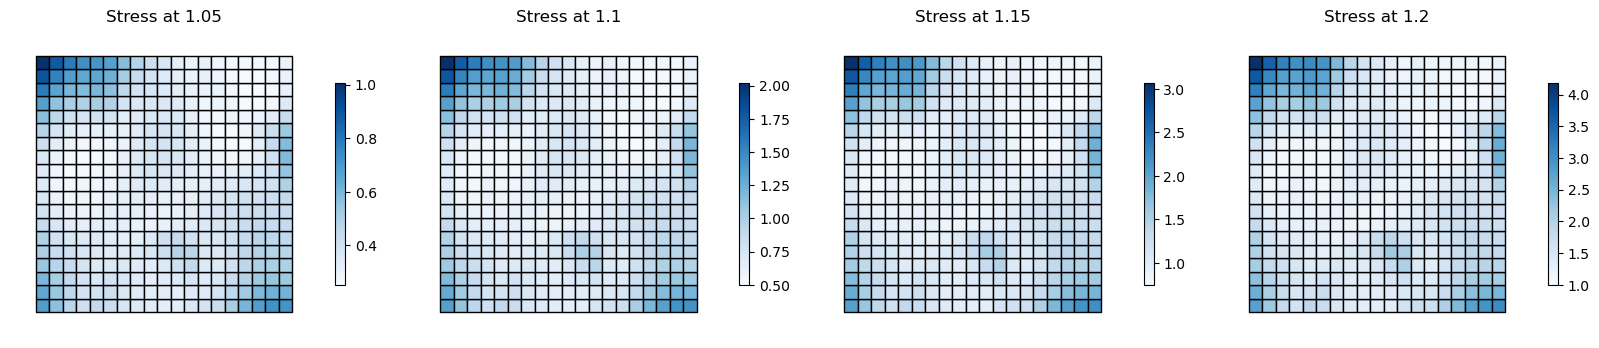

In [14]:
# Stiffness across the domain
fig, axes = plt.subplots(1,4,figsize=(20,4))
for lmb, ax in zip(lmb_hist, axes):
    c_elem = []
    for x, y in elem_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_w_unravel(phi)
        c_elem.append(eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0])
    c_elem = np.array(c_elem)
    plotmesh(mesh.cells, mesh.points, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [15]:
from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

In [16]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [17]:
# Do the FEM with jax-fem instead
def NODE_PK1(u_grad, params, dim):
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    # Energy/Stress
    model = NODE_w_unravel(params)
    Psi1 = model.Psi1(I1,I2,Iv,Iw)
    Psi2 = model.Psi2(I1,I2,Iv,Iw)
    Psiv = model.Psiv(I1,I2,Iv,Iw)
    Psiw = model.Psiw(I1,I2,Iv,Iw)
    
    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
NODE_vmap = vmap(NODE_PK1, in_axes=(0,0,None))
def NODE_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = NODE_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
NODE_sigma_vmap = vmap(NODE_sigma, in_axes=(0,0,None))
class NODE_HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: NODE_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [18]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = NODE_HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = NODE_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[12-11 17:22:38][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-11 17:22:38][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-11 17:22:38][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-11 17:22:39][DEBUG] jax_fem: Done pre-computations, took 0.34505176544189453 [s]
[12-11 17:22:39][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-11 17:22:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-11 17:22:39][DEBUG] jax_fem: Start timing
[12-11 17:22:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-11 17:22:41][DEBUG] jax_fem: Function split_and_compute_cell took 2.8210 seconds
[12-11 17:22:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-11 17:22:42][DEBUG] jax_fem: Linear guess solve...
[12-11 17:22:42][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-11 17:22:42][DEBUG] jax_fem: PETSc

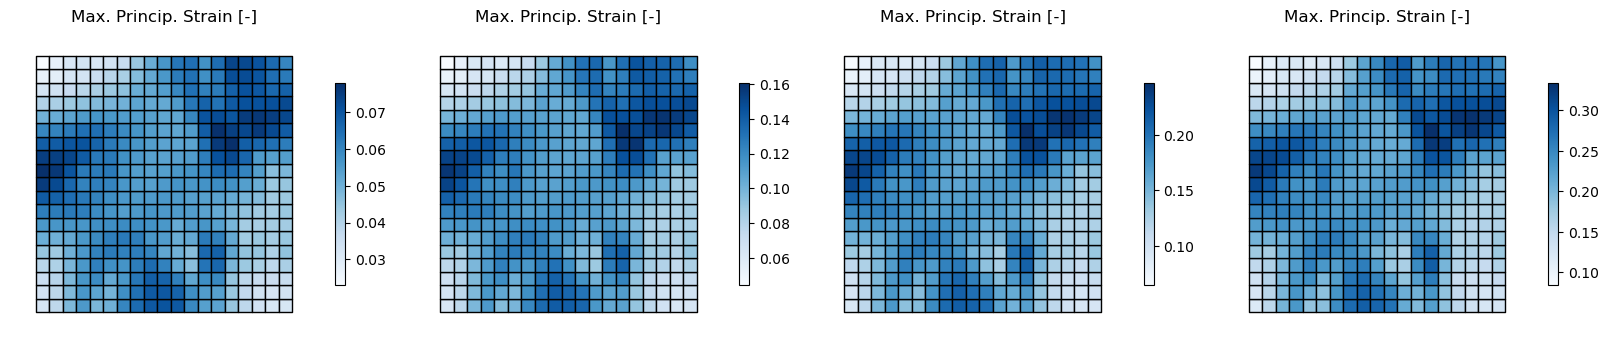

In [19]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 